<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>

In [ ]:
# required modules (skip if already installed)
!pip install pyroaring
!pip install pyfim 
# if previous does not work, try: !conda install -c conda-forge pyfim
!pip install lightgbm
!pip install fairlearn

In [2]:
try:
    # if using Colab
    import google.colab
    wdir = 'https://raw.githubusercontent.com/ruggieris/DD/main/'
    # download source
    !wget --no-cache --backups=1 -O dd.py {wdir}'dd.py'
except:
    wdir = '' # local files
print('Working dir: ', wdir)

Working dir:  


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import dd
import pandas as pd
import numpy as np
import seaborn as sns

# Part I

In [4]:
# Sample data: credit.csv, adult.csv or any other dataset with discrete columns only.
df = pd.read_csv(wdir+'data/credit.csv', sep=',', na_values='?')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,lt_0,le_17d6,critical_or_other_existing_credit,radio_or_tv,le_38848d8,no_known_savings,ge_7,gt_2d8,male_single,none,...,real_estate,gt_52d6,none,own,from_1d6_le_2d2,skilled,le_1d2,yes,no,good
1,from_0_lt_200,gt_31d2,existing_paid,radio_or_tv,from_38848d8_le_7519d6,lt_100,from_1_lt_4,from_1d6_le_2d2,female_div_or_dep_or_mar,none,...,real_estate,le_30d2,none,own,le_1d6,skilled,le_1d2,none,no,bad
2,no_checking,le_17d6,critical_or_other_existing_credit,education,le_38848d8,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,none,...,real_estate,from_41d4_le_52d6,none,own,le_1d6,unskilled_resident,gt_1d2,none,no,good
3,lt_0,gt_31d2,existing_paid,furniture_or_equipment,from_7519d6_le_11154d4,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,guarantor,...,life_insurance,from_41d4_le_52d6,none,for_free,le_1d6,skilled,gt_1d2,none,no,good
4,lt_0,from_17d6_le_31d2,delayed_previously,new_car,from_38848d8_le_7519d6,lt_100,from_1_lt_4,gt_2d8,male_single,none,...,no_known_property,gt_52d6,none,for_free,from_1d6_le_2d2,skilled,gt_1d2,none,no,bad


In [5]:
# DD(filename or dataframe, unprotected item, negative decision)
#disc = dd.DD(df, 'foreign_worker=no', 'class=bad')
disc = dd.DD(df, 'age=from_41d4_le_52d6', 'class=bad')
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("RD = {:f}".format(ctg.rd()))    

-----
Context = ALL
Size = 1000  Perc = 100.00%
                     |class=bad|class=good|   
age=gt_52d6          |       29|        67| 96
age=from_41d4_le_52d6|       39|       122|161
                     |       68|       189|257
RD = 0.059847
-----
Context = ALL
Size = 1000  Perc = 100.00%
                     |class=bad|class=good|   
age=le_30d2          |      148|       263|411
age=from_41d4_le_52d6|       39|       122|161
                     |      187|       385|572
RD = 0.117861
-----
Context = ALL
Size = 1000  Perc = 100.00%
                     |class=bad|class=good|   
age=from_30d2_le_41d4|       84|       248|332
age=from_41d4_le_52d6|       39|       122|161
                     |      123|       370|493
RD = 0.010776


In [6]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for independence
     =========== dec.deny === dec.grant === 
     protected     a            b     n1()
     unprotected   c            d     n2()
     ===========   m1() ===   m2()  == n()
'''
def check_rd(ctg):
    # at least 20 protected with dec.deny and p2() != 0
    if ctg.a < 20 or ctg.c==0:
        return None
    return ctg.rd()

def check_rr(ctg):
    # at least 20 protected with dec.deny and p2() != 0
    if ctg.a < 20 or ctg.c==0:
        return None
    return ctg.rr()

In [7]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# topk = top k contingency tables
ctgs_rd = disc.extract(testCond=check_rd, minSupp=-20, topk=1000)

In [8]:
# print top 2 
for v, ctg in ctgs_rd[:3]:
    disc.print(ctg)
    print("RD = {:f}".format(v))

-----
Context = duration=gt_31d2 AND existing_credits=from_1d6_le_2d2 AND foreign_worker=no
Size = 60  Perc = 6.00%
                     |class=bad|class=good|  
age=le_30d2          |       21|         6|27
age=from_41d4_le_52d6|        1|         4| 5
                     |       22|        10|32
RD = 0.577778
-----
Context = purpose=new_car AND personal_status=female_div_or_dep_or_mar AND credit_amount=le_38848d8 AND foreign_worker=no
Size = 57  Perc = 5.70%
                     |class=bad|class=good|  
age=le_30d2          |       20|         8|28
age=from_41d4_le_52d6|        1|         4| 5
                     |       21|        12|33
RD = 0.514286
-----
Context = purpose=new_car AND personal_status=female_div_or_dep_or_mar AND credit_amount=le_38848d8
Size = 58  Perc = 5.80%
                     |class=bad|class=good|  
age=le_30d2          |       20|         8|28
age=from_41d4_le_52d6|        1|         4| 5
                     |       21|        12|33
RD = 0.514286


In [9]:
# contingency tables wrt RR
ctgs_rr = disc.extract(testCond=check_rr, minSupp=-20, topk=1000)
for v, ctg in ctgs_rr[:3]:
    disc.print(ctg)
    print("RR = {:f}".format(v))

-----
Context = residence_since=gt_2d8 AND job=skilled AND credit_amount=le_38848d8 AND other_payment_plans=none
Size = 225  Perc = 22.50%
                     |class=bad|class=good|   
age=le_30d2          |       29|        57| 86
age=from_41d4_le_52d6|        1|        35| 36
                     |       30|        92|122
RR = 12.139535
-----
Context = residence_since=gt_2d8 AND job=skilled AND installment_commitment=gt_2d8 AND credit_amount=le_38848d8 AND other_payment_plans=none
Size = 164  Perc = 16.40%
                     |class=bad|class=good|  
age=le_30d2          |       23|        31|54
age=from_41d4_le_52d6|        1|        27|28
                     |       24|        58|82
RR = 11.925926
-----
Context = residence_since=gt_2d8 AND job=skilled AND credit_amount=le_38848d8 AND other_payment_plans=none AND foreign_worker=no
Size = 218  Perc = 21.80%
                     |class=bad|class=good|   
age=le_30d2          |       29|        55| 84
age=from_41d4_le_52d6|        1

In [10]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg[1] for ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg[1] for ctg in ctgs_rr)
# contingency tables in both
shared = ct_rd_set & ct_rr_set
len(shared) 

431

Text(0, 0.5, 'p2')

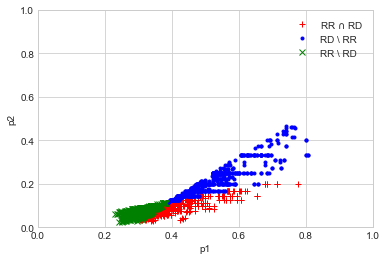

In [11]:
# plot p1() vs p2()
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')

# Part II

In [12]:
# Adult dataset
adult = pd.read_csv(wdir+'data/adult_discrete.csv', sep=',', na_values='?')
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,(33.5-41.5],State-gov,(-inf-106068.5],Bachelors,(10.5-13.5],Never-married,Adm-clerical,Not-in-family,White,Male,(57-3368],(-inf-77.5],(39.5-40.5],United-States,-50K
1,(41.5-50.5],Self-emp-not-inc,(-inf-106068.5],Bachelors,(10.5-13.5],Married-civ-spouse,Exec-managerial,Husband,White,Male,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K
2,(33.5-41.5],Private,(196318-260259.5],HS-grad,(8.5-9.5],Divorced,Handlers-cleaners,Not-in-family,White,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K
3,(50.5-inf),Private,(196318-260259.5],11th,(-inf-8.5],Married-civ-spouse,Handlers-cleaners,Husband,NonWhite,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K
4,(25.5-33.5],Private,(260259.5-inf),Bachelors,(10.5-13.5],Married-civ-spouse,Prof-specialty,Wife,NonWhite,Female,(-inf-57],(-inf-77.5],(39.5-40.5],Cuba,-50K


In [13]:
# Encode categorical values
df, encoders = dd.encode(adult)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,2.0,6.0,0.0,9.0,1.0,4.0,0.0,1.0,1.0,1.0,3.0,0.0,2.0,38.0,1.0
1,3.0,5.0,0.0,9.0,1.0,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,38.0,1.0
2,2.0,3.0,3.0,11.0,3.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,2.0,38.0,1.0
3,4.0,3.0,3.0,1.0,0.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,2.0,38.0,1.0
4,1.0,3.0,4.0,9.0,1.0,2.0,9.0,5.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0


In [14]:
# there are missing values (but LightGBM deal with them! no need for imputation methods)
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

In [15]:
# df has categorical features (but LightGBM deal with them! no need for one-hot encoding)
df.dtypes

age               category
workclass         category
fnlwgt            category
education         category
education-num     category
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain      category
capital-loss      category
hours-per-week    category
native-country    category
class             category
dtype: object

In [16]:
# split train test
from sklearn.model_selection import train_test_split

X = df[df.columns.drop('class')]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, adult_train, adult_test = train_test_split(X, y, adult.copy(), test_size=0.33, random_state=42)

In [17]:
# training model and make predictions 
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
adult_test['predicted'] = encoders['class'].inverse_transform(clf.predict(X_test))
adult_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,predicted
7762,(-inf-25.5],Private,(260259.5-inf),HS-grad,(8.5-9.5],Never-married,Other-service,Not-in-family,White,Male,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K
23881,(-inf-25.5],Private,(157936.5-196318],12th,(-inf-8.5],Never-married,Sales,Own-child,White,Female,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K
30507,(-inf-25.5],Local-gov,(260259.5-inf),HS-grad,(8.5-9.5],Never-married,Handlers-cleaners,Other-relative,NonWhite,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K,-50K
28911,(-inf-25.5],Private,(196318-260259.5],Some-college,(9.5-10.5],Never-married,Sales,Own-child,White,Female,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K
19484,(41.5-50.5],Private,(196318-260259.5],HS-grad,(8.5-9.5],Never-married,Machine-op-inspct,Unmarried,NonWhite,Male,(-inf-57],(-inf-77.5],(50.5-inf),Puerto-Rico,-50K,-50K


In [18]:
# discrimination in test set
disc = dd.DD(adult_test, 'race=White', 'class=-50K', 'predicted=-50K', na_values={'nan'}) 
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(ctg.tpr_diff()))

-----
Context = ALL
Size = 16118  Perc = 100.00%
race=NonWhite                                      race=White
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          1895|            75| 1970     class=-50K|          9542|           692|10234
class=+50K|           155|           205|  360     class=+50K|          1333|          2221| 3554
          |          2050|           280| 2330               |         10875|          2913|13788
TPR Male = 0.877425
TPR Female = 0.924390
tpr_diff = -0.046965


In [39]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for separation
          protected                               unprotected
     ========== tru.deny == true.grant ===   === tru.deny == true.grant === 
     dec.deny    TPp         FPp       a          TPu          FPu       c
     dec.grant   FNp         TNp       b          FNu          TNu       d
     ==========  Pp()  ===== Np() ===  n1()  ===  Pu()  ====   Nu() ===  n2()
'''
def check_tpr(ctg):
    # at least 20 protected with dec.deny and p2() != 0
    if ctg.Pu() < 20 or ctg.Pp() < 20 or ctg.Np()==0 or ctg.Nu()==0:
        return None
    return ctg.tpr_diff()

In [40]:
# Extract contingency tables: 
ctgs_tpr = disc.extract(testCond=check_tpr, minSupp=-100, topk=1000)

In [41]:
for v, ctg in ctgs_tpr[:3]:
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(v))

-----
Context = fnlwgt=(157936.5-196318] AND education=Some-college AND sex=Male AND workclass=Private AND capital-gain=(-inf-57] AND education-num=(9.5-10.5]
Size = 262  Perc = 1.63%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            13|             2| 15     class=-50K|           152|            20|172
class=+50K|             8|             1|  9     class=+50K|            27|            39| 66
          |            21|             3| 24               |           179|            59|238
TPR Male = 0.849162
TPR Female = 0.619048
tpr_diff = 0.230114
-----
Context = education=Bachelors AND hours-per-week=(40.5-50.5] AND capital-gain=(-inf-57] AND education-num=(10.5-13.5]
Size = 615  Perc = 3.82%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|    

In [42]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
X_train = X_train.fillna(0) # fairlearn does not manage missing values
X_test = X_test.fillna(0) # fairlearn does not manage missing values
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['sex'])
# fair-corrected predictions 
adult_test['predicted'] = encoders['class'].inverse_transform(
                            postprocess_est.predict(X_test, sensitive_features=X_test['sex']).astype(int))

In [43]:
# discrimination in test set
disc = dd.DD(adult_test, 'race=White', 'class=-50K', 'predicted=-50K', na_values={'nan'}) 
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(ctg.tpr_diff()))

-----
Context = ALL
Size = 16118  Perc = 100.00%
race=NonWhite                                      race=White
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          1816|           154| 1970     class=-50K|          9232|          1002|10234
class=+50K|           152|           208|  360     class=+50K|          1296|          2258| 3554
          |          1968|           362| 2330               |         10528|          3260|13788
TPR Male = 0.876900
TPR Female = 0.922764
tpr_diff = -0.045865


In [44]:
# Extract contingency tables: 
ctgs_tpr_post = disc.extract(testCond=check_tpr, minSupp=-100, topk=1000)

In [45]:
for v, ctg in ctgs_tpr_post[:3]:
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(v))

-----
Context = education=Bachelors AND hours-per-week=(40.5-50.5] AND capital-gain=(-inf-57] AND education-num=(10.5-13.5]
Size = 615  Perc = 3.82%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            16|             7| 23     class=-50K|           208|            73|281
class=+50K|            12|            12| 24     class=+50K|            49|           238|287
          |            28|            19| 47               |           257|           311|568
TPR Male = 0.809339
TPR Female = 0.571429
tpr_diff = 0.237910
-----
Context = education=Bachelors AND hours-per-week=(40.5-50.5] AND capital-gain=(-inf-57] AND capital-loss=(-inf-77.5] AND education-num=(10.5-13.5]
Size = 567  Perc = 3.52%
race=NonWhite                                    race=White
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|          

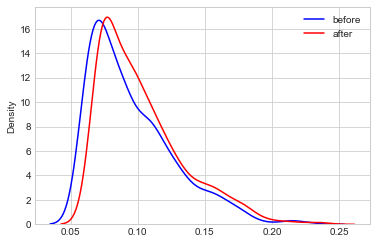

In [46]:
sns.set_style('whitegrid')
sns.kdeplot(np.array([v for v, _ in ctgs_tpr]), bw_adjust=1.0, color='b', label="before")
sns.kdeplot(np.array([v for v, _ in ctgs_tpr_post]), bw_adjust=1.0, color='r', label="after")
plt.legend(labels=['before', 'after'])